# HCA B lineage pseudotime and RNA velocity

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#HVG>2.3 Highly variable genes</a>
    * <a href=#Visualization>2.4 Visualization</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#TI>3.2 Trajectory inference</a>
      * <a href=#DPT>3.2.1 Diffusion Pseudotime</a>
    * <a href=#Velocity>3.3 Velocity analysis </a>
      * <a href=#velo_deter>3.3.1. Deterministic velocity model</a>

# 0. Loading the libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import anndata as ad
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sb
import scvelo as scv
import re

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

/work/juha/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
sc.logging.print_versions()

scanpy==1.4.5.dev130+g0612475 anndata==0.6.22.post1+1.g8dcc3cd umap==0.3.9 numpy==1.18.1 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=60, dpi_save=160, vector_friendly=True)

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)

In [5]:
# Some parameters
results_file = '/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/scanpy/hg19/new_2019/cellranger3/subset3/HCA_subset3_pseudotime_scDD_CC_genes.h5ad'

In [6]:
# Colors
cmap = matplotlib.cm.get_cmap('rainbow') # HCA B lineage cluster colors
cmap_louvain = [cmap(i) for i in [i / 10 for i in range(0,11)]]

def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def create_cmap(low, high, N=256):
    vals = np.ones((N, 4))
    low = hex_to_RGB(low)
    high = hex_to_RGB(high)
    vals[:,0] = np.linspace(low[0]/256, high[0]/256, N)
    vals[:,1] = np.linspace(low[1]/256, high[1]/256, N)
    vals[:,2] = np.linspace(low[2]/256, high[2]/256, N)
    newcmp = ListedColormap(vals)
    return newcmp

cmap_gexp = create_cmap('#D3D3D3', '#A30059') # For individual gene plotting

<a id="Reading"></a>

# 1. Reading in the data


In [8]:
X = pd.read_csv('/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/scanpy/hg19/new_2019/cellranger3/subset3/data/raw/X_allgenes.csv.gz', header=None)

obs = pd.read_csv('/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/scanpy/hg19/new_2019/cellranger3/subset3/data/obs.csv', index_col=0)
var = pd.read_csv('/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/scanpy/hg19/new_2019/cellranger3/subset3/data/raw/var_allgenes.txt', header=None, index_col=0)

In [9]:
X.columns = var.index
X['index'] = obs.index
X = X.set_index('index')

In [10]:
adata = ad.AnnData(X=X, obs=obs, var=var)

In [11]:
# Check everything is okay.
adata

AnnData object with n_obs × n_vars = 20753 × 32738 
    obs: 'batch', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'louvain', 'S_score', 'G2M_score', 'phase', 'in_previous_dataset', 'celltype_old', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'dd_predicted_doublet', 'celltype', 'chen_pnone0162638_pro-B', 'chen_pnone0162638_immature_B', 'chen_pnone0162638_CLP', 'chen_pnone0162638_pre-B'

In [12]:
# Delete unnecessary variables
del X, obs, var

In [13]:
# Save
adata.write(results_file)

... storing 'batch' as categorical
... storing 'phase' as categorical
... storing 'celltype_old' as categorical
... storing 'celltype' as categorical


<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

In [14]:
# Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells=1)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
filtered out 10662 genes that are detected in less than 1 cells
Number of genes after cell filter: 22076


In [15]:
adata.obs['celltype'].value_counts()

7_immatureB        8164
6_preB_G1          3783
1_HSC              3660
4_proB_G1          1743
5_preB_G2MS        1714
2_earlyLymphoid     895
3_proB_G2MS         794
Name: celltype, dtype: int64

<a id="Normalization"></a>

## 2.2 Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

In [16]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:03)


In [17]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [18]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [19]:
#Delete adata_pp
del adata_pp

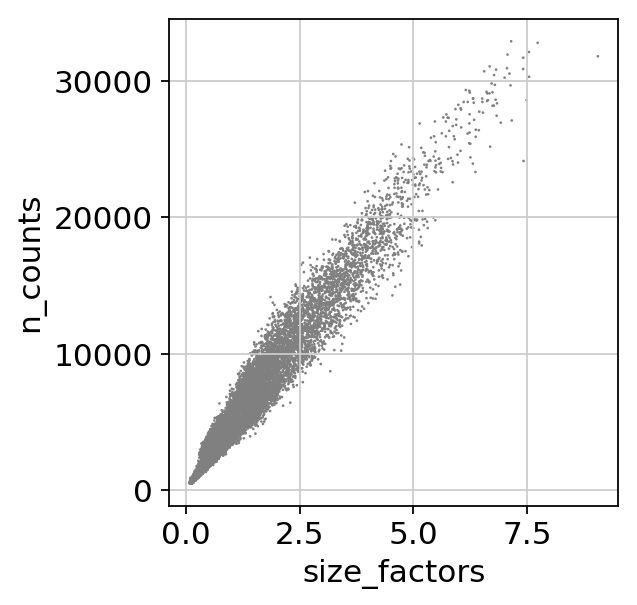

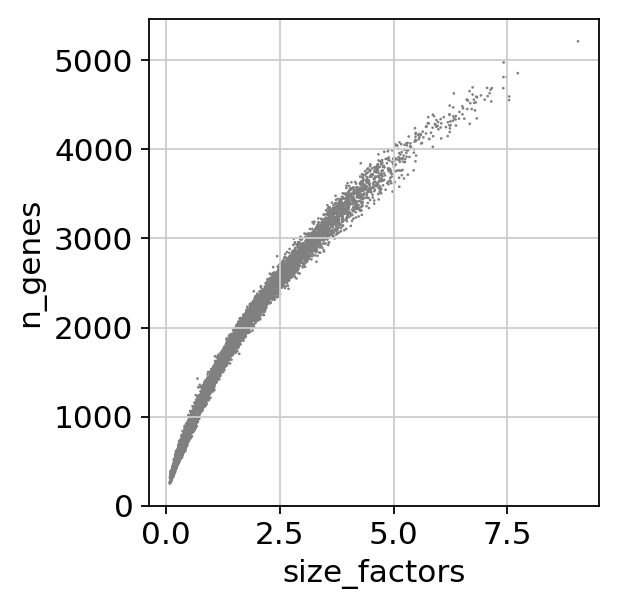

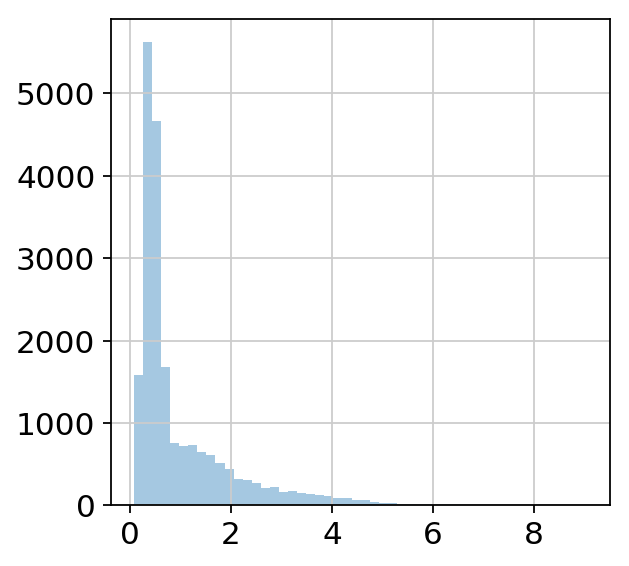

In [20]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [21]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [22]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [23]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

<a id="HVG"></a>

## 2.3 Highly Variable Genes

Instead of using HVGs, we use genes statistically significant genes from scDD analysis between different celltypes.

In [39]:
with open('/research/groups/allseq/data/scRNAseq/results/ER_project/new_2019/scDD/vst/scDD_genes.txt') as file:
    scDD_genes = file.read().splitlines()
    
with open('/research/groups/allseq/data/scRNAseq/results/juha_wrk/resources/regev_lab_cell_cycle_genes_S_phase.txt') as file:
    s_genes = file.read().splitlines()

with open('/research/groups/allseq/data/scRNAseq/results/juha_wrk/resources/regev_lab_cell_cycle_genes_G2M_phase.txt') as file:
    g2m_genes = file.read().splitlines()

genes = scDD_genes + s_genes + g2m_genes

adata.var['highly_variable'] = adata.var_names.isin(genes)

In [26]:
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 1621


The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- log-normalized data in adata.X
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

<a id="Visualization"></a>

## 2.4 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [29]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=15, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)

computing PCA with n_comps = 15
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99929285 0.99819756 0.9971841  0.99678946 0.991518
     0.98874205 0.9851504  0.9802382  0.97804374 0.9752294  0.97154194
     0.96762764 0.9674495  0.96477175]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:03)


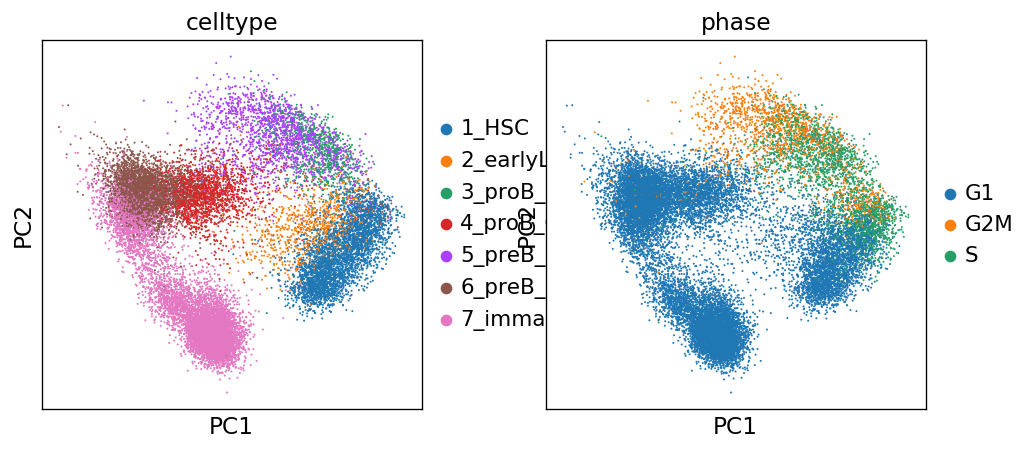

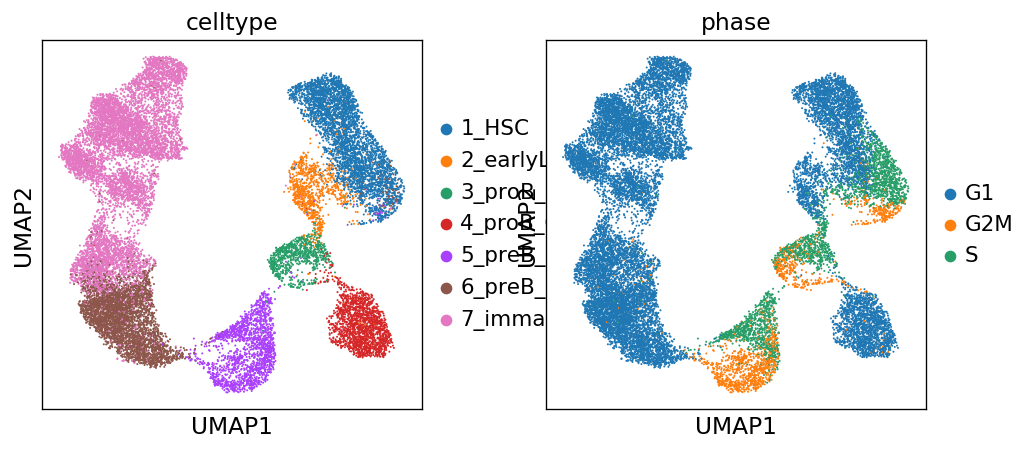

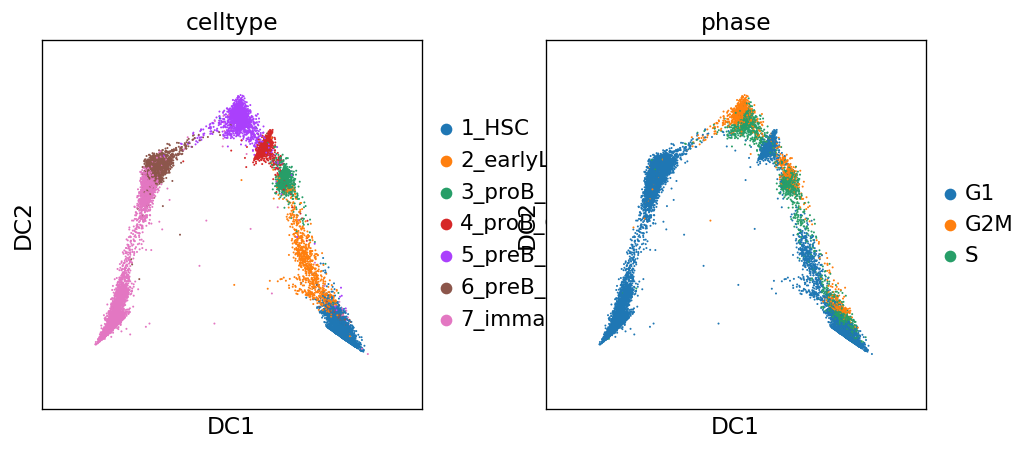

In [13]:
sc.pl.pca_scatter(adata, color=['celltype', 'phase'])
sc.pl.umap(adata, color=['celltype', 'phase'])
sc.pl.diffmap(adata, color=['celltype', 'phase'])

<a id="Downstream"></a>

# 3 Downstream analysis

<a id="Clustering"></a>

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section.

Modularity optimization via louvain has a stochastic element to it. This stochasticity typically does not affect the biological interpretation of the data, but can change the details of analysis scripts. Normally scanpy fixes the random seed to 0 to make scripts exactly reproducible. 

In [31]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:03)


In [32]:
mapping = {
0:'7',
1:'11',
2:'9',
3:'2',
4:'8',
5:'5',
6:'6',
7:'1',
8:'10',
9:'3',
10:'4'
}
adata.obs['louvain2'] = adata.obs['louvain'].astype('int16').map(mapping).astype('category')
adata.obs['louvain2'] = pd.Series(pd.Categorical(adata.obs['louvain2'], categories=[str(i) for i in range(1,12)]), index=adata.obs_names)
adata.uns['louvain2_colors'] = cmap_louvain

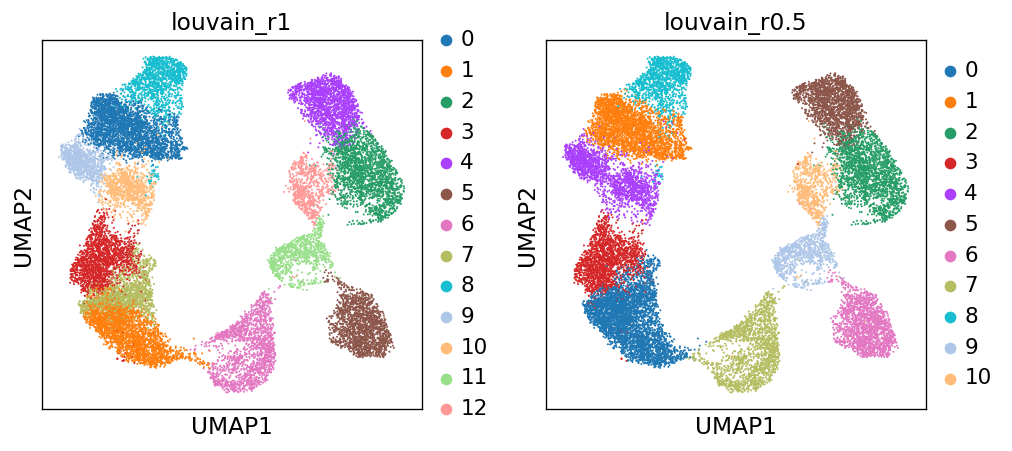

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

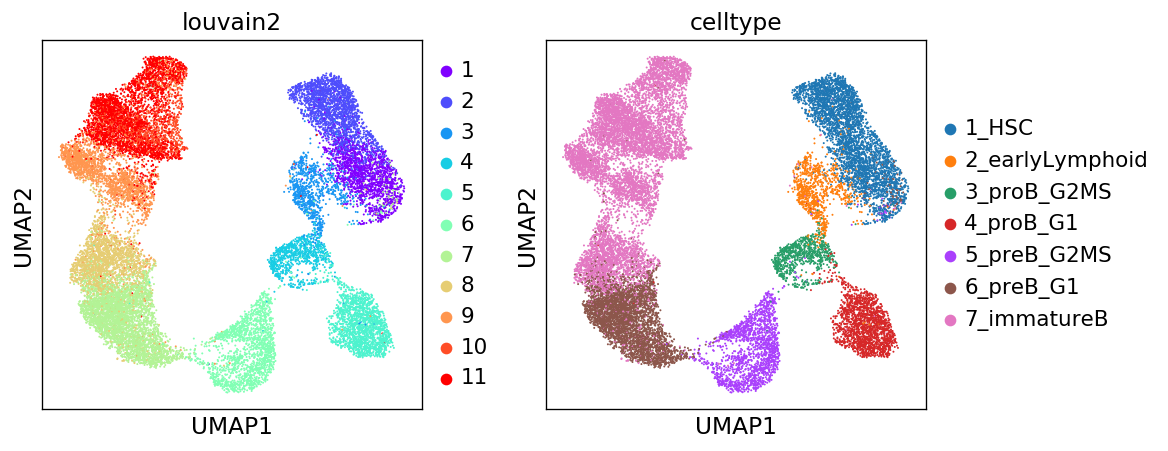

In [12]:
# Visualize the clustering
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'])
sc.pl.umap(adata, color=['louvain2', 'celltype'])

<a id="TI"></a>

## 3.2 Trajectory inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

<a id="DPT"></a>

### 3.2.1 Diffusion Pseudotime (DPT)

We include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In DPT we must assign a root cell to infer pseudotime. In the plots we can observe that the most appropriate root will be the HSC with the minimum DC1 value.

Note that 0-th column in `adata.obsm['X_diffmap']` is the steady-state solution, which is non-informative in diffusion maps.

In [34]:
# Find the HSC with the highest DC1 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata.obs['celltype'], '1_HSC')
max_stem_id = np.argmax(adata.obsm['X_diffmap'][stem_mask,1])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata.uns['iroot'] = root_id

In [35]:
# Compute dpt
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


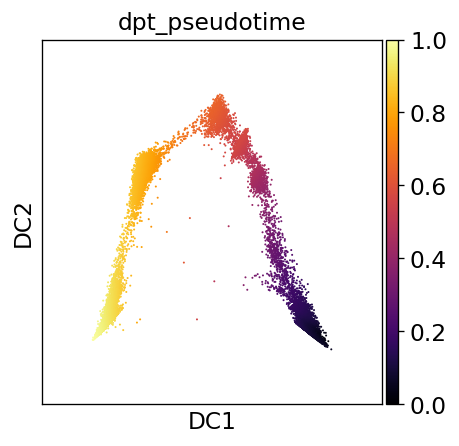

In [8]:
# Visualize pseudotime over differentiation
sc.pl.diffmap(adata, color='dpt_pseudotime', color_map='inferno')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

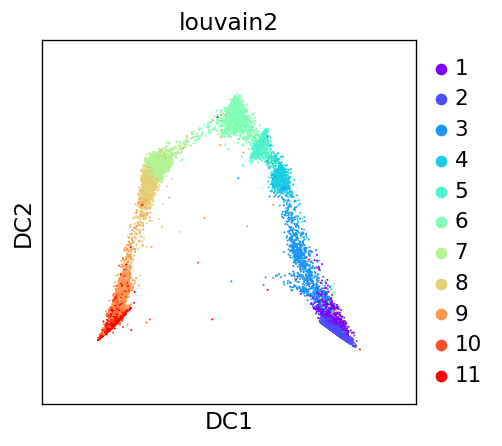

In [10]:
sc.pl.diffmap(adata, color='louvain2')

In [37]:
adata.write(results_file)

<a id="Velocity"></a>

## 3.3 Velocity analysis

Velocity analysis using spliced/unspliced counts quantified with Velocyto CLI. First we run the deterministic/steady state model (the original model from <a href=https://doi.org/10.1038/s41586-018-0414-6>La Manno et al., 2018</a>) and then we try the stochastic and the dynamical models from <a href=https://github.com/theislab/scvelo>scVelo</a> package (<a href=https://doi.org/10.1101/820936>preprint</a>).

The loom file used is obtained from running velocyto CLI separately for all HCA BM samples and then combining the produced loom files together.

In [16]:
# Initial stuff
scv.settings.set_figure_params('scvelo')
results_file_velo = '/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/scanpy/hg19/new_2019/cellranger3/subset3/HCA_subset3_velocity_FINAL.h5ad'
loom = '/research/groups/biowhat_share/public_data/scRNAseq/Human_Cell_Atlas_Preview_Datasets/immune_census/velocyto/HCA_Blineage_velocyto.loom'

In [59]:
# Combine original data with velocyto data
adata_loom = scv.read(loom, cache=False)
adata_2 = adata.copy()
#adata_2 = sc.read(results_file)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [60]:
# Cell ids are a bit different coming from velocyto, modify ids to match them
new_cellids_adata = [re.sub('-1-MantonBM.$', '', x) for x in adata_2.obs_names]
new_cellids_loom = [re.sub(':', '-', x) for x in adata_loom.obs_names]
new_cellids_loom = [re.sub('x$', '', x) for x in new_cellids_loom]

adata_2.obs['index'] = new_cellids_adata
adata_2.obs = adata_2.obs.set_index('index')
adata_loom.obs['index'] = new_cellids_loom
adata_loom.obs = adata_loom.obs.set_index('index')

In [61]:
# Merge datas
adata_v = scv.utils.merge(adata_2, adata_loom)

In [25]:
# Fix colors before plotting (merge messed them up probably)
adata_v.uns['louvain2_colors'] = [tuple(row) for row in adata_v.uns['louvain2_colors']]

In [16]:
# Show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata_v)
adata_v

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.66 0.27 0.06]


AnnData object with n_obs × n_vars = 20753 × 22076 
    obs: 'batch', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'louvain', 'S_score', 'G2M_score', 'phase', 'in_previous_dataset', 'celltype_old', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'dd_predicted_doublet', 'celltype', 'chen_pnone0162638_pro-B', 'chen_pnone0162638_immature_B', 'chen_pnone0162638_CLP', 'chen_pnone0162638_pre-B', 'size_factors', 'louvain_r1', 'louvain_r0.5', 'louvain2', 'dpt_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'n_cells', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors', 'celltype_sizes', 'diffmap_evals', 'iroot', 'louvain', 'louvain2_colors', 'louvain_r0.5_colors', 'louvain_r1_colors', 'neighbors', 'paga', 'pca', 'phase_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [17]:
# Clean up adata
scv.utils.cleanup(adata_v)
del adata_2
adata_v

AnnData object with n_obs × n_vars = 20753 × 22076 
    obs: 'batch', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'louvain', 'S_score', 'G2M_score', 'phase', 'in_previous_dataset', 'celltype_old', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'dd_predicted_doublet', 'celltype', 'chen_pnone0162638_pro-B', 'chen_pnone0162638_immature_B', 'chen_pnone0162638_CLP', 'chen_pnone0162638_pre-B', 'size_factors', 'louvain_r1', 'louvain_r0.5', 'louvain2', 'dpt_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'n_cells', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors', 'celltype_sizes', 'diffmap_evals', 'iroot', 'louvain', 'louvain2_colors', 'louvain_r0.5_colors', 'louvain_r1_colors', 'neighbors', 'paga', 'pca', 'phase_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

In [18]:
# Filter data
scv.pp.filter_and_normalize(adata_v, min_shared_counts=10, n_top_genes=3000)

Filtered out 12955 genes that are detected in less than 10 counts (shared).
Normalized count data: spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


In [19]:
# Calculate first and second order moments.
# First order is needed for deterministic velocity estimation,
# while stochastic estimation also requires second order moments.
scv.pp.moments(adata_v, n_pcs=30, n_neighbors=30)

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    finished (0:00:12) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [20]:
adata_v

AnnData object with n_obs × n_vars = 20753 × 3000 
    obs: 'batch', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'louvain', 'S_score', 'G2M_score', 'phase', 'in_previous_dataset', 'celltype_old', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'dd_predicted_doublet', 'celltype', 'chen_pnone0162638_pro-B', 'chen_pnone0162638_immature_B', 'chen_pnone0162638_CLP', 'chen_pnone0162638_pre-B', 'size_factors', 'louvain_r1', 'louvain_r0.5', 'louvain2', 'dpt_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'n_cells', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'celltype_sizes', 'diffmap_evals', 'iroot', 'louvain', 'louvain2_colors', 'louvain_r0.5_colors', 'louvain_r1_colors', 'neighbors', 'paga', 'pca', 'phase_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'

In [50]:
adata_v.write(results_file_velo)

<a id='velo_deter'></a>

### 3.3.1. Deterministic velocity model

In [30]:
# Compute velocities and velocity graph
scv.tl.velocity(adata_v, mode='deterministic')
scv.tl.velocity_graph(adata_v)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:44) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


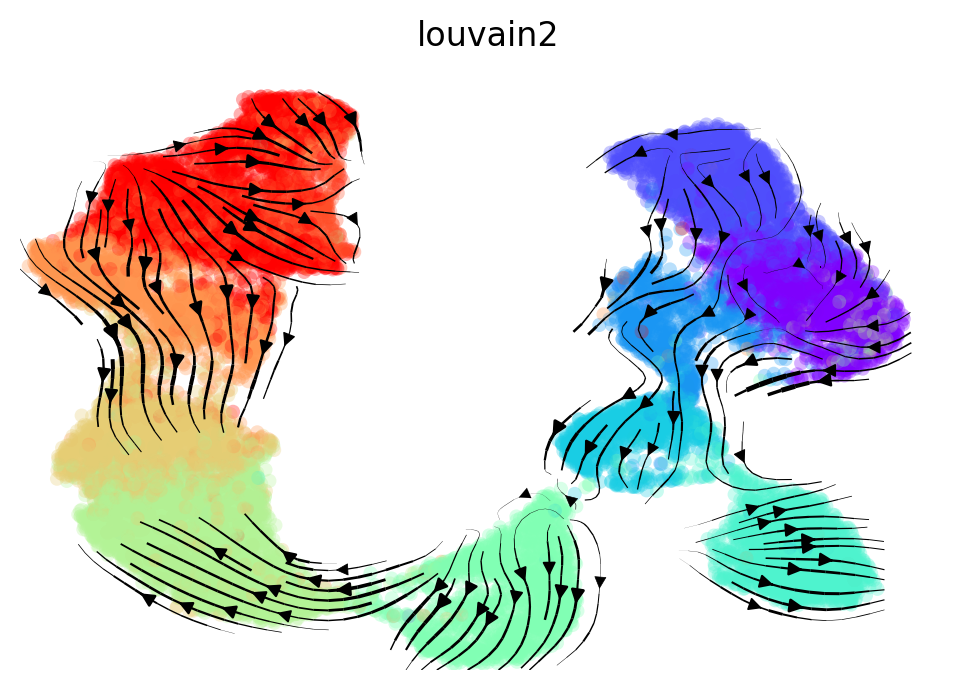

In [31]:
# Embed velocities
scv.pl.velocity_embedding_stream(adata_v, basis='umap', legend_loc='none', color='louvain2')

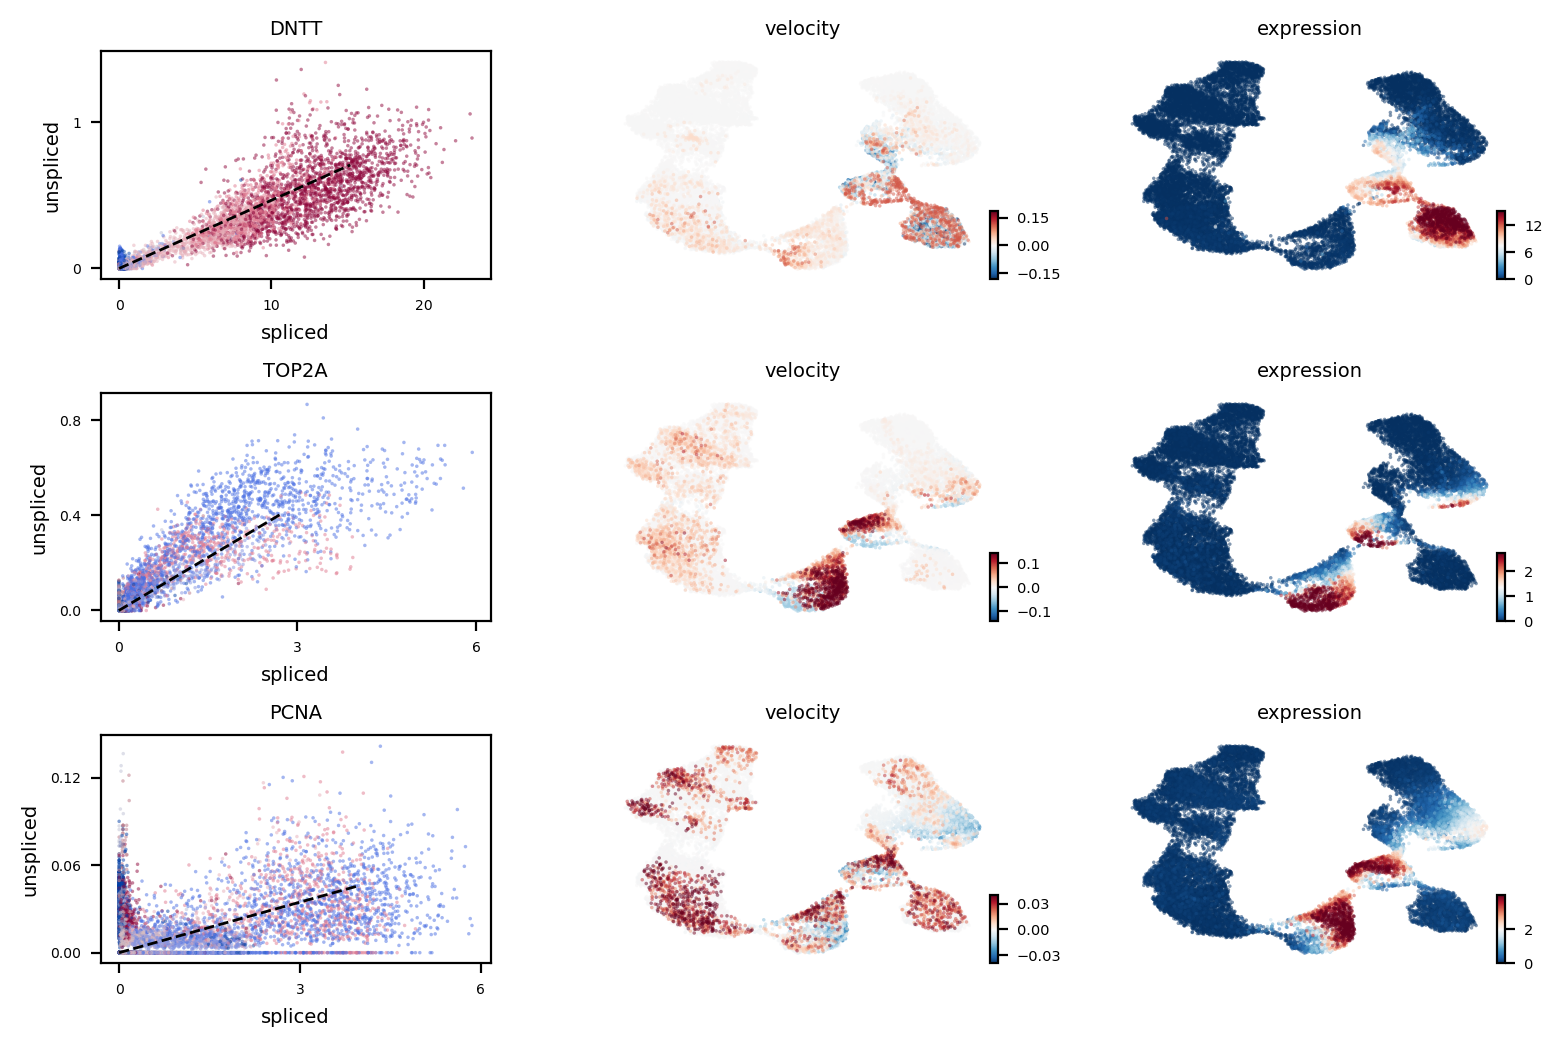

In [34]:
scv.pl.velocity(adata_v, var_names=['DNTT', 'TOP2A', 'PCNA'], ncols=1, colorbar=True, fontsize=7, color_map='RdBu_r')